In [1]:
import torch
from transformers import SamModel, SamProcessor

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

model = SamModel.from_pretrained("facebook/sam-vit-base").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

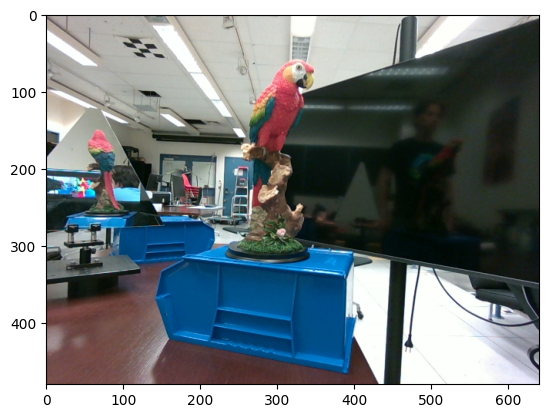

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import requests

image = Image.open('/home/research/Columbia/CI-Project/data/parrot_test_5_Color.png')

plt.imshow(image)

In [5]:
# input_points = [[[76, 181]]]
input_points = [[[305, 127]]]
inputs = processor(image, input_points=input_points, return_tensors="pt").to(device)

with torch.no_grad():
    outputs = model(**inputs)
masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())

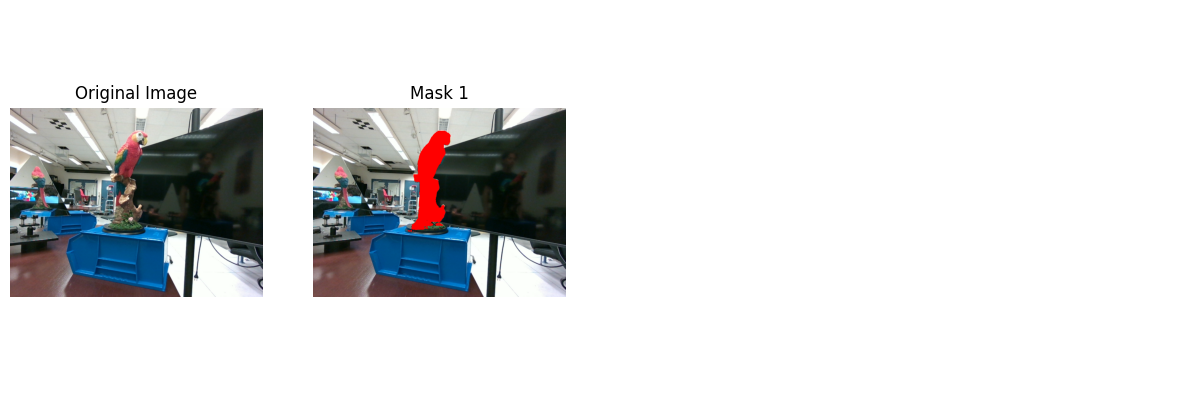

In [6]:
import torch
import numpy as np

fig, axes = plt.subplots(1, 4, figsize=(15, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')
mask_list = [masks[0][0][0].numpy()]

for i, mask in enumerate(mask_list, start=1):
    overlayed_image = np.array(image).copy()

    overlayed_image[:,:,0] = np.where(mask == 1, 255, overlayed_image[:,:,0])
    overlayed_image[:,:,1] = np.where(mask == 1, 0, overlayed_image[:,:,1])
    overlayed_image[:,:,2] = np.where(mask == 1, 0, overlayed_image[:,:,2])
    
    axes[i].imshow(overlayed_image)
    axes[i].set_title(f'Mask {i}')
for ax in axes:
    ax.axis('off')

plt.show()

In [69]:
mask = masks[0][0][0].numpy()

In [70]:
mask.shape

(480, 640)

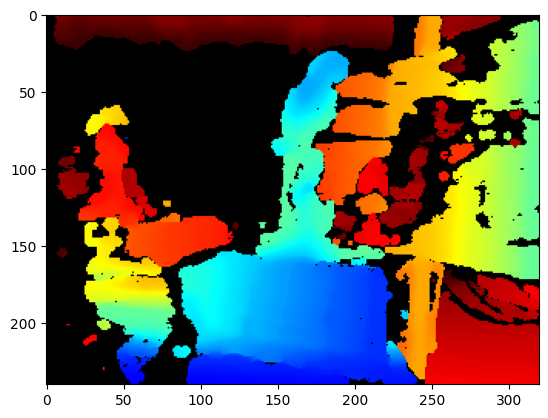

In [71]:
dimage = Image.open('/home/research/Columbia/CI-Project/data/parrot_test_5_D_Depth.png')

plt.imshow(dimage)

depth_map = np.array(Image.open('/home/research/Columbia/CI-Project/data/parrot_test_5_D_Depth.png'))

In [72]:
import cv2 

def upsample_depth(rgb_depth_map, target_size):
    upsampled_rgb_depth_map = cv2.resize(rgb_depth_map, target_size[::-1], interpolation=cv2.INTER_CUBIC)
    return upsampled_rgb_depth_map

depth_map = upsample_depth(depth_map, mask.shape)

In [77]:

def shift_mask_right(mask, shift_x):

    if shift_x < 0:
        raise ValueError("shift_x must be a non-negative integer")
    
    shifted_mask = np.zeros_like(mask, dtype=bool)
    
    if shift_x > 0:
        shifted_mask[:, shift_x:] = mask[:, :-shift_x]
    
    return shifted_mask

smask = shift_mask_right(mask, 35)

In [78]:
def apply_mask_to_map(mask, rgb_depth_map):
    # rgb depth map should have been loaded already
    # make sure that the map and te depth map have the same shape
    mask = mask.astype(bool)
    
    # Extract RGB values where the mask is True
    rgb_values = rgb_depth_map[mask]

    return rgb_values

In [79]:
masked_rgb_values = apply_mask_to_map(smask, depth_map)


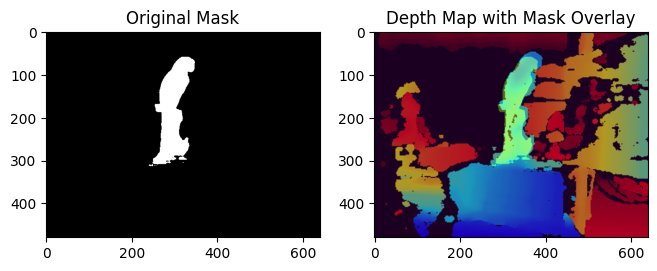

In [80]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(mask, cmap='gray')
plt.title('Original Mask')
plt.subplot(1, 3, 2)
plt.imshow(depth_map)
plt.imshow(smask, alpha=0.4)
plt.title('Depth Map with Mask Overlay')
plt.show()

In [81]:
masked_rgb_values

array([[  0, 207, 253],
       [  0, 205, 254],
       [  0, 203, 254],
       ...,
       [  0, 231, 253],
       [  0, 231, 254],
       [  0, 231, 254]], dtype=uint8)

In [84]:
def extract_mean_rgb(rgb_values):
    """Computes the mean in each channel with the nonzero elements"""
    masked_rgb = np.ma.masked_equal(rgb_values, 0)
    mean_rgb = np.ma.mean(masked_rgb, axis=0).filled(np.nan)  

    return mean_rgb

mean_rgb = extract_mean_rgb(masked_rgb_values)
print("Mean RGB values excluding zeros:", mean_rgb)


Mean RGB values excluding zeros: [ 48.91500757 229.95234294 211.61862917]
